In [48]:
from pathlib import Path
import json
from itertools import chain
from IPython.display import Markdown
import matplotlib.pyplot as plt
import polars as pl
import pickle
from langchain_text_splitters import RecursiveCharacterTextSplitter

## Loading

In [21]:
data_folder = Path("./data/")
len(list(data_folder.iterdir()))

47

In [22]:
with open("codexes.json", "r") as f:
    codexes = json.load(f)
with open("laws.json", "r") as f:
    laws = json.load(f)
    
len(codexes) + len(laws)

47

In [ ]:
docs = {}
for doc_name, doc_title in chain(codexes.items(), laws.items()):
    with open(data_folder / doc_name) as f:
        docs[doc_title] = f.read()

len(docs)

47

## Analysing

In [32]:
Markdown(next(iter(docs)) + '\n\n' + next(iter(docs.values()))[:500])

Конституция Российской Федерации (принята всенародным голосованием 12.12.1993 с изменениями, одобренными в ходе общероссийского голосования 01.07.2020)

РАЗДЕЛ ПЕРВЫЙ


ГЛАВА 1.

ОСНОВЫ КОНСТИТУЦИОННОГО СТРОЯ


Статья 1


1. Российская Федерация - Россия есть демократическое федеративное правовое государство с республиканской формой правления.

2. Наименования Российская Федерация и Россия равнозначны.


Статья 2


Человек, его права и свободы являются высшей ценностью. Признание, соблюдение и защита прав и свобод человека и гражданина - обязанность государства.


Статья 3


1. Носителем суверенитета и единственным источником власти в Российской

In [35]:
lengths = [len(title) + len(doc) for title, doc in docs.items()]
pl.Series(lengths).describe()

statistic,value
str,f64
"""count""",47.0
"""null_count""",0.0
"""mean""",606745.276596
"""std""",738877.365533
"""min""",77541.0
"""25%""",195072.0
"""50%""",364878.0
"""75%""",712525.0
"""max""",4.445184e6


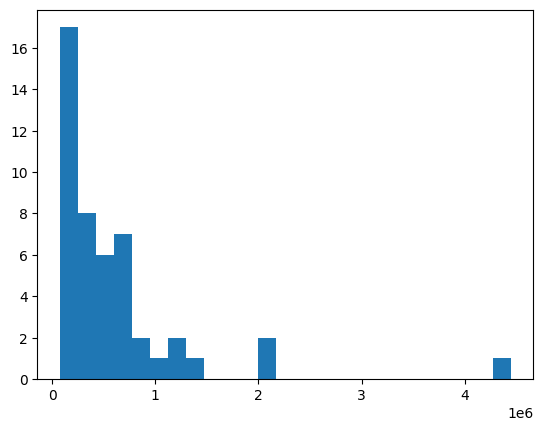

In [38]:
plt.hist(lengths, bins=25);

## Splitting

We are using `deepvk/USER-bge-m3` model for embeddings. It has 8k max length of tokens. So i think it's appropriate to split text into a chunks of 2500 symbols with 20% overlap.

In [39]:
chunk_size = 2500
chunk_overlap_factor = 0.2

In [41]:
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n\n", "\n\n", "\n", " ", ""],
    chunk_size=chunk_size,
    chunk_overlap=int(chunk_size * chunk_overlap_factor),
    is_separator_regex=False,
)

In [42]:
chunks = splitter.create_documents(list(docs.values()), metadatas=[{"title": t} for t in docs.keys()])
f"{len(chunks)} chunks was construct from {len(docs)} docs"

'17285 chunks was construct from 47 docs'

In [45]:
Markdown(chunks[0].metadata['title'] + '\n' + chunks[0].page_content)

Конституция Российской Федерации (принята всенародным голосованием 12.12.1993 с изменениями, одобренными в ходе общероссийского голосования 01.07.2020)
РАЗДЕЛ ПЕРВЫЙ


ГЛАВА 1.

ОСНОВЫ КОНСТИТУЦИОННОГО СТРОЯ


Статья 1


1. Российская Федерация - Россия есть демократическое федеративное правовое государство с республиканской формой правления.

2. Наименования Российская Федерация и Россия равнозначны.


Статья 2


Человек, его права и свободы являются высшей ценностью. Признание, соблюдение и защита прав и свобод человека и гражданина - обязанность государства.


Статья 3


1. Носителем суверенитета и единственным источником власти в Российской Федерации является ее многонациональный народ.

2. Народ осуществляет свою власть непосредственно, а также через органы государственной власти и органы местного самоуправления.

3. Высшим непосредственным выражением власти народа являются референдум и свободные выборы.

4. Никто не может присваивать власть в Российской Федерации. Захват власти или присвоение властных полномочий преследуются по федеральному закону.


Статья 4


1. Суверенитет Российской Федерации распространяется на всю ее территорию.

2. Конституция Российской Федерации и федеральные законы имеют верховенство на всей территории Российской Федерации.

3. Российская Федерация обеспечивает целостность и неприкосновенность своей территории.


Статья 5


1. Российская Федерация состоит из республик, краев, областей, городов федерального значения, автономной области, автономных округов - равноправных субъектов Российской Федерации.

2. Республика (государство) имеет свою конституцию и законодательство. Край, область, город федерального значения, автономная область, автономный округ имеет свой устав и законодательство.

3. Федеративное устройство Российской Федерации основано на ее государственной целостности, единстве системы государственной власти, разграничении предметов ведения и полномочий между органами государственной власти Российской Федерации и органами государственной власти субъектов Российской Федерации, равноправии и самоопределении народов в Российской Федерации.

4. Во взаимоотношениях с федеральными органами государственной власти все субъекты Российской Федерации между собой равноправны.


Статья 6

## Saving

In [49]:
with open(data_folder / "chunks.pkl", "wb") as f:
    pickle.dump(chunks, f)